In [4]:
# Import required libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Check Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f" PyTorch version: {torch.__version__}")
print(f" Device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
else:
    print(" WARNING: You are running on CPU. Go to Runtime -> Change runtime type -> T4 GPU for faster training.")

 PyTorch version: 2.9.0+cu126
 Device: cuda
   GPU: Tesla T4


In [ ]:
# Load AG News dataset from Hugging Face
print("Loading AG News dataset...")
dataset = load_dataset("ag_news")

print(" Dataset loaded successfully!\n")
print(f"Training samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")

label_names = ['World', 'Sports', 'Business', 'Sci/Tech']
print(f"\nCategories: {label_names}")

Loading AG News dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

✅ Dataset loaded successfully!

Training samples: 120000
Test samples: 7600

Categories: ['World', 'Sports', 'Business', 'Sci/Tech']


First 5 training examples:

[Example 1] Category: Business
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\b...

[Example 2] Category: Business
Text: Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,...

[Example 3] Category: Business
Text: Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about th...

[Example 4] Category: Business
Text: Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil e...

[Example 5] Category: Business
Text: Oil prices soar to all-time record, posing new menace to US economy (AFP) AFP - Tearaway world oil p...


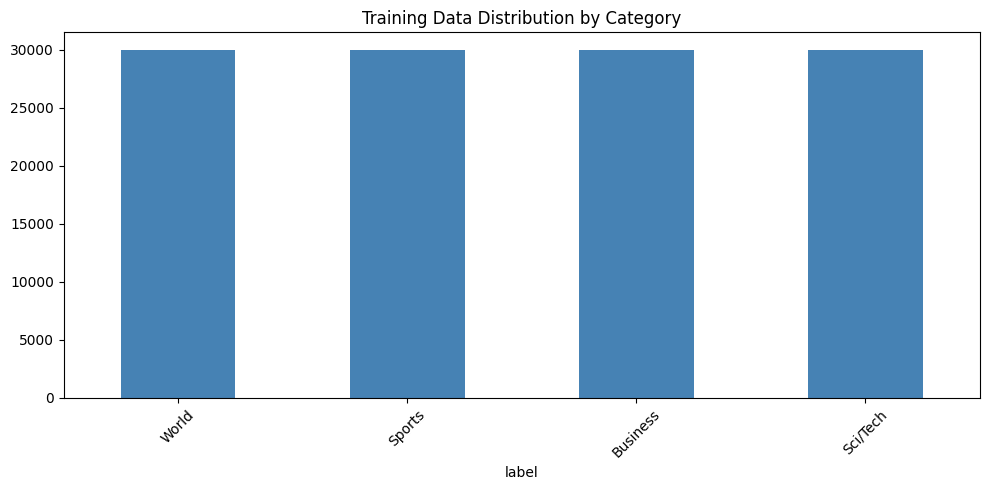

In [6]:
# Show sample data
print("First 5 training examples:")
print("="*80)
for idx in range(5):
    example = dataset['train'][idx]
    label = label_names[example['label']]
    print(f"\n[Example {idx+1}] Category: {label}")
    print(f"Text: {example['text'][:100]}...")

# Visualize distribution
train_df = pd.DataFrame(dataset['train'])
plt.figure(figsize=(10, 5))
train_df['label'].value_counts().sort_index().plot(kind='bar', color='steelblue')
plt.title('Training Data Distribution by Category')
plt.xticks(range(4), label_names, rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Load BERT tokenizer
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(" Tokenizer loaded!")

# Test tokenizer
sample = "Apple releases new iPhone with AI features"
tokens = tokenizer.tokenize(sample)
print(f"\nExample: {sample}")
print(f"Tokens: {tokens}")

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Tokenizer loaded!

Example: Apple releases new iPhone with AI features
Tokens: ['apple', 'releases', 'new', 'iphone', 'with', 'ai', 'features']


In [8]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Tokenize
print("Tokenizing datasets (this takes a moment)...")
tokenized_train = dataset['train'].map(tokenize_function, batched=True)
tokenized_test = dataset['test'].map(tokenize_function, batched=True)

print(" Tokenization complete!")

Tokenizing datasets (this takes a moment)...


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

 Tokenization complete!


In [9]:
# Use a subset for faster training in this tutorial
# 10,000 training samples, 1,000 test samples
small_train = tokenized_train.shuffle(seed=42).select(range(10000))
small_test = tokenized_test.shuffle(seed=42).select(range(1000))

print(f" Training on subset: {len(small_train)} samples")
print(f" Testing on subset: {len(small_test)} samples")

 Training on subset: 10000 samples
 Testing on subset: 1000 samples


In [10]:
# Load BERT model
print("Loading BERT model...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=4
)
model.to(device) # Move model to GPU

print(" BERT model loaded!")

Loading BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 BERT model loaded!


In [11]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')

    return {'accuracy': accuracy, 'f1': f1}

In [12]:
# Training configuration
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # 2 epochs is usually enough for BERT
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",           # Fixed parameter name
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,                       # Use mixed precision (faster on GPU)
    report_to="none"                 # Disable external logging for simplicity
)

print(" Training configured!")

 Training configured!


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_test,
    compute_metrics=compute_metrics,
)

print(" Trainer initialized!")

 Trainer initialized!


In [14]:
print(" STARTING TRAINING")
trainer.train()
print(" TRAINING COMPLETE!")

 STARTING TRAINING


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.284800,0.288002,0.904000,0.903921
2,0.199600,0.308102,0.907000,0.907717
3,0.072600,0.335308,0.912000,0.912076


 TRAINING COMPLETE!


In [15]:
print("Evaluating model...")
eval_results = trainer.evaluate()

print(f"\nAccuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1 Score: {eval_results['eval_f1']:.4f}")

Evaluating model...



Accuracy: 0.9120
F1 Score: 0.9121


In [16]:
print("Generating predictions...")
predictions = trainer.predict(small_test)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Show detailed report
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels, target_names=label_names))

Generating predictions...



Classification Report:
              precision    recall  f1-score   support

       World       0.94      0.90      0.92       266
      Sports       0.98      0.99      0.98       246
    Business       0.89      0.85      0.87       246
    Sci/Tech       0.85      0.90      0.87       242

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



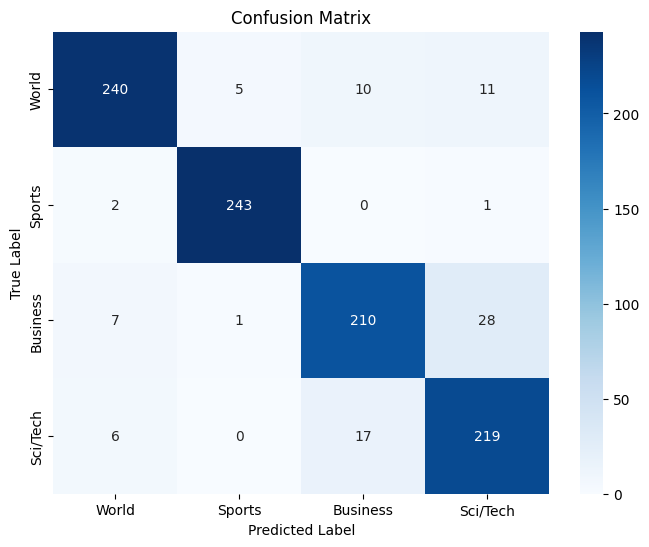

In [17]:
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [19]:
def predict_headline(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()} # Move inputs to GPU

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_idx = torch.argmax(probs).item()
        confidence = probs[0][pred_idx].item()

    return label_names[pred_idx], confidence

# Test
headlines = [
    "Stock market hits record high as tech shares rally",
    "NASA launches new rover to Mars",
    "Manchester United wins final match",
    "President signs new climate change bill"
]

print(" Custom Predictions:")
for h in headlines:
    cat, conf = predict_headline(h)
    print(f"Headline: {h}")
    print(f"Prediction: {cat} ({conf:.1%})\n")

 Custom Predictions:
Headline: Stock market hits record high as tech shares rally
Prediction: Sci/Tech (69.3%)

Headline: NASA launches new rover to Mars
Prediction: Sci/Tech (99.4%)

Headline: Manchester United wins final match
Prediction: Sports (99.8%)

Headline: President signs new climate change bill
Prediction: Sci/Tech (96.1%)



In [20]:
save_path = './my_bert_news_model'
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(f" Model saved to {save_path}")

 Model saved to ./my_bert_news_model


In [23]:
# Easy prediction function
def predict_news_category(text):
    inputs = tokenizer(text, padding='max_length',
                      truncation=True, max_length=128,
                      return_tensors='pt')

    # Move inputs to the same device as the model (GPU)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][pred_class].item()

    return {
        'category': label_names[pred_class],
        'confidence': confidence
    }

print(" Prediction function created!")

# Test it
result = predict_news_category("Apple announces new iPhone")
print(f"\nTest: {result['category']} ({result['confidence']*100:.1f}%)")

 Prediction function created!

Test: Sci/Tech (98.7%)
